In [2]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from scipy.stats import wilcoxon
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('Solarize_Light2')
import seaborn as sns

idx = pd.IndexSlice

In [3]:
# import data
conn = sqlite3.Connection('Northwind_large.sqlite')
cur = conn.cursor()

In [4]:
#what tables are available in the database
cur.execute("""SELECT name 
               FROM sqlite_master
               WHERE type = 'table';""")
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',),
 ('sqlite_sequence',)]

In [6]:
# Order data
cur.execute("""SELECT *
               FROM 'Order';
               """)
df_order = pd.DataFrame(cur.fetchall())
df_order.columns = [x[0] for x in cur.description]
df_order.sample(3)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
9651,19899,VICTE,5,2013-02-18 23:39:35,2013-03-19 06:37:59,2013-03-03 23:25:29,1,336.25,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1388,11636,ERNSH,8,2013-04-30 22:21:19,2013-06-03 13:32:15,2013-05-21 19:13:03,2,459.25,Königlich Essen,Maubelstr. 90,Brandenburg,Western Europe,14776,Germany
10924,21172,BSBEV,4,2015-12-16 00:40:08,2015-12-25 23:24:26,2015-12-19 21:49:35,1,71.00,Königlich Essen,Maubelstr. 90,Brandenburg,Western Europe,14776,Germany


In [9]:
# Product data
cur.execute("""select od.ProductID, o.EmployeeID, o.CustomerID, o.OrderDate AS orderDate,
                o.Id AS orderID, od.quantity AS Quantity, od.unitPrice,
                od.quantity * od.unitPrice as total        
              from 'Order' o, OrderDetail od
              where o.ID = od.OrderId;
               """)
df_sales = pd.DataFrame(cur.fetchall())
df_sales.columns = [x[0] for x in cur.description]
df_sales.sample(5)

,ProductId,EmployeeId,CustomerId,orderDate,orderID,Quantity,UnitPrice,total
258505,12,9,CONSH,2012-10-17 13:31:37,17655,39,38.0,1482.0
528554,49,1,QUICK,2014-10-15 00:10:54,24653,42,20.0,840.0
195092,10,1,THEBI,2013-03-05 17:42:42,16044,5,31.0,155.0
408495,53,3,TORTU,2014-07-04 13:11:12,21500,14,32.8,459.2
84744,63,6,ERNSH,2015-09-14 17:26:50,13222,40,43.9,1756.0


### Manage n/a data types

In [12]:
# nans identification
print(len(df_sales))

621883


### Remove duplicate data

In [13]:
# identification of duplicate data
print('duplicated rows: ' + str(df_sales.duplicated().sum()))

duplicated rows: 0


In [14]:
#vacio

df_sales.columns = df_sales.columns.str.strip()

### Manage data types

First, let's see what the data types for this data set are.

In [16]:
df_sales['orderDate'] = pd.to_datetime(df_sales['orderDate'])

In [17]:
# data type identification
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621883 entries, 0 to 621882
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ProductId   621883 non-null  int64         
 1   EmployeeId  621883 non-null  int64         
 2   CustomerId  621883 non-null  object        
 3   orderDate   621883 non-null  datetime64[ns]
 4   orderID     621883 non-null  int64         
 5   Quantity    621883 non-null  int64         
 6   UnitPrice   621883 non-null  float64       
 7   total       621883 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 38.0+ MB


### Remove outliers

In [24]:
df_sales = df_sales[df_sales['ProductId']!=11]
df_drop = df_sales[df_sales['ProductId']!=42]

In [27]:
df_sales.sample(5)

,ProductId,EmployeeId,CustomerId,orderDate,orderID,Quantity,UnitPrice,total
212742,17,4,FRANR,2014-03-21 02:04:32,16501,42,39.0,1638.0
55486,36,8,LAZYK,2014-01-01 10:52:56,12456,17,19.0,323.0
423868,32,5,KOENE,2014-12-21 17:37:25,21898,10,32.0,320.0
246788,18,6,THECR,2013-05-31 02:11:18,17362,23,62.5,1437.5
555032,62,9,LAZYK,2014-02-23 16:21:33,25337,22,49.3,1084.6


length of cleaner dataset: 605758


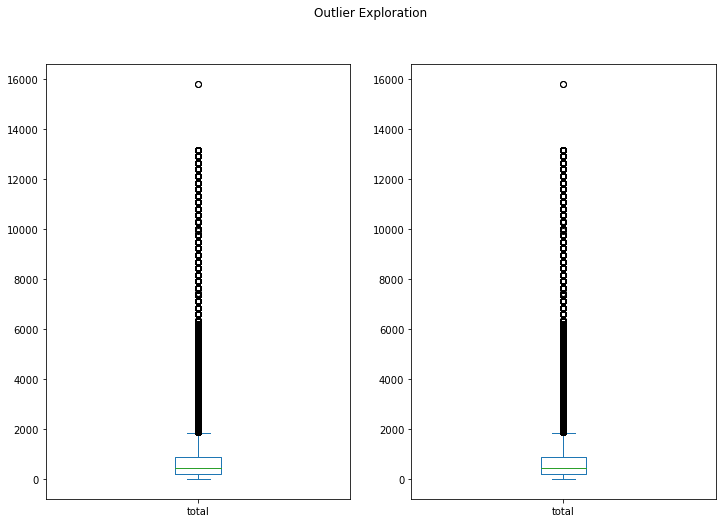

In [32]:
# outlier identification
print('length of cleaner dataset: ' + str(len(df_drop)))

fig01 = plt.figure(figsize=(12,8))
fig01.suptitle('Outlier Exploration')

ax = fig01.add_subplot(121)
ax1 = df_drop.total.plot(kind='box')
ax = fig01.add_subplot(122)
ax2 = df_drop.total.plot(kind='box')

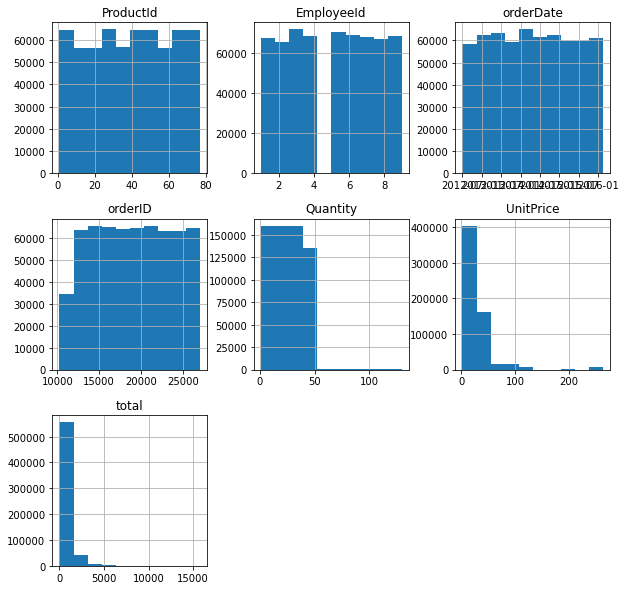

In [34]:
# visualize data
df_sales.hist(figsize=(10,10));

In [35]:
df_sales.to_csv(r'Sales.csv')